In [1]:
from langchain_groq import ChatGroq
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

model = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [2]:
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of th report"
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report"
    )

planner = model.with_structured_output(Sections)

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [11]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send

def orchestrator(state: State):
    """ Orchestrator that generates a plan for the report """

    if 'topic' not in state:
        raise ValueError("Required key 'topic' is missing from state")
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections": report_sections.sections}

def llmCall(state: WorkerState):
    """ Worker writes the section of the report """

    section = model.invoke(
        [
            SystemMessage(content="Write a report section"),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )
    return {"competed_sections": [section.content]}

def synthesizer(state:State):
    """ Synthesize the full report from sections. """

    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

def assignWorkers(state:State):
    """ Assign a worker to each section of the plan. """
    return [Send("llmCall", {"section": s}) for s in state["sections"]]

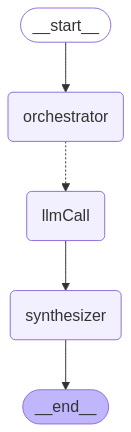

In [12]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node("orchestrator",orchestrator)
builder.add_node("llmCall",llmCall)
builder.add_node("synthesizer",synthesizer)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assignWorkers, ["llmCall"])
builder.add_edge("llmCall", "synthesizer")
builder.add_edge("synthesizer", END)

graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state: State = {
    "topic": "tesla stock",
    "sections": [],
    "completed_sections": [],
    "final_report": ""
}

response = graph.invoke(initial_state)

In [14]:
response

{'topic': 'tesla stock',
 'sections': [Section(name='Introduction', description='Overview of Tesla and its stock performance'),
  Section(name='Financial Analysis', description="In-depth review of Tesla's financial statements and stock trends"),
  Section(name='Market Trends', description="Analysis of the current market trends and their impact on Tesla's stock"),
  Section(name='Conclusion', description="Summary of key findings and future outlook for Tesla's stock")],
 'completed_sections': [],
 'final_report': ''}

In [15]:
response["sections"]

[Section(name='Introduction', description='Overview of Tesla and its stock performance'),
 Section(name='Financial Analysis', description="In-depth review of Tesla's financial statements and stock trends"),
 Section(name='Market Trends', description="Analysis of the current market trends and their impact on Tesla's stock"),
 Section(name='Conclusion', description="Summary of key findings and future outlook for Tesla's stock")]

In [18]:
response["final_report"]

''

In [24]:
from IPython.display import Markdown
Markdown(response["final_report"])

In [25]:
from langchain_groq import ChatGroq
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [26]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [27]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [30]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [32]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
# display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [33]:
state = orchestrator_worker.invoke({"topic": "Create a report on tesla stocks"})
from IPython.display import Markdown

Markdown(state["final_report"])

**Introduction and Description: Overview of Tesla and its Stock Performance**

Tesla, Inc. is a pioneering American electric vehicle (EV) and clean energy company founded in 2003 by Elon Musk, Martin Eberhard, Marc Tarpenning, JB Straubel, and Ian Wright. Headquartered in Austin, Texas, Tesla has revolutionized the automotive industry with its innovative electric vehicles, energy storage systems, and solar panel products. The company's mission is to accelerate the world's transition to sustainable energy through the production of electric vehicles, solar power systems, and energy storage products.

In recent years, Tesla has experienced significant growth and has become one of the most valuable companies in the world. The company's stock, listed on the NASDAQ exchange under the ticker symbol TSLA, has been highly volatile, with its price fluctuating rapidly in response to various market and economic factors. Despite the volatility, Tesla's stock has generally trended upward over the past decade, with the company's market capitalization surpassing $1 trillion in 2021.

Tesla's stock performance has been influenced by a range of factors, including the company's financial performance, product launches, regulatory developments, and global economic trends. The company's ability to consistently deliver strong revenue growth, expand its product offerings, and navigate the complex regulatory landscape of the automotive and energy industries has contributed to its stock's upward trajectory. However, the company has also faced challenges, including intense competition, supply chain disruptions, and concerns about the sustainability of its business model.

This report will provide an in-depth analysis of Tesla's stock performance, including its historical trends, volatility, and responsiveness to various market and economic factors. The report will also examine the company's financial performance, product offerings, and strategic initiatives, as well as the key drivers of its stock price and the outlook for its future growth and development. By exploring these topics in detail, this report aims to provide a comprehensive understanding of Tesla and its stock performance, and to identify potential opportunities and challenges for investors and stakeholders.

---

**Market Analysis and Description: Analysis of the Current Market Trends and their Impact on Tesla Stocks**

The electric vehicle (EV) market has experienced significant growth in recent years, driven by increasing consumer demand for sustainable and environmentally friendly transportation options. As a pioneer in the EV industry, Tesla, Inc. has been at the forefront of this trend, with its stocks closely tied to the overall performance of the market. This section provides an analysis of the current market trends and their impact on Tesla stocks.

**Current Market Trends:**

1. **Increasing Demand for Electric Vehicles:** The global EV market is expected to continue its upward trajectory, with sales projected to reach 14 million units by 2025, up from 2 million units in 2020. This growth is driven by government incentives, declining battery costs, and improving charging infrastructure.
2. **Competition and Market Saturation:** The EV market is becoming increasingly competitive, with traditional automakers such as General Motors, Volkswagen, and Nissan entering the space. This increased competition may lead to market saturation, potentially impacting Tesla's market share and stock price.
3. **Technological Advancements:** Advances in battery technology, autonomous driving, and vehicle-to-grid (V2G) capabilities are expected to drive innovation in the EV industry. Tesla's ability to stay ahead of the curve in terms of technology and innovation will be crucial in maintaining its competitive edge.
4. **Regulatory Environment:** Government policies and regulations, such as tax credits and emissions standards, play a significant role in shaping the EV market. Changes in these policies can impact demand for EVs and, subsequently, Tesla's stock price.

**Impact on Tesla Stocks:**

1. **Stock Price Volatility:** Tesla's stock price has historically been volatile, with significant fluctuations in response to market trends, company announcements, and regulatory changes.
2. **Growth Prospects:** The growing demand for EVs and Tesla's position as a market leader contribute to the company's growth prospects, which are reflected in its stock price.
3. **Competition and Market Share:** The increasing competition in the EV market may lead to a decline in Tesla's market share, potentially impacting its stock price.
4. **Innovation and Technological Advancements:** Tesla's ability to innovate and stay ahead of the competition in terms of technology and features will be crucial in maintaining its competitive edge and driving long-term growth.

**Conclusion:**

The current market trends in the EV industry have a significant impact on Tesla's stock price. While the growing demand for EVs and Tesla's position as a market leader contribute to the company's growth prospects, increasing competition and market saturation may pose challenges. Tesla's ability to innovate and stay ahead of the curve in terms of technology and features will be crucial in maintaining its competitive edge and driving long-term growth. As the EV market continues to evolve, investors should closely monitor these trends and their impact on Tesla's stock price.

---

**Financial Performance**

Tesla, Inc. has experienced significant fluctuations in its financial performance over the years, which has had a substantial impact on its stock prices. This section provides an in-depth review of the company's financial statements and their effect on stock prices.

**Revenue Growth**

Tesla's revenue has consistently increased over the years, driven by the growing demand for electric vehicles (EVs) and the company's expanding product lineup. In 2022, the company reported a revenue of $81.5 billion, representing a 51% increase from the previous year. This growth can be attributed to the increasing popularity of Tesla's models, such as the Model 3 and Model Y, as well as the company's efforts to expand its presence in international markets.

**Net Income**

Tesla's net income has also shown significant improvement in recent years. In 2022, the company reported a net income of $12.6 billion, representing a 155% increase from the previous year. This increase can be attributed to the company's ability to maintain its pricing power, reduce production costs, and improve its operational efficiency.

**Gross Margin**

Tesla's gross margin has been steadily increasing over the years, driven by the company's efforts to reduce production costs and improve its operational efficiency. In 2022, the company reported a gross margin of 25.1%, representing a 2.5% increase from the previous year. This increase has been driven by the company's ability to reduce its production costs, improve its supply chain management, and increase its economies of scale.

**Stock Price Performance**

Tesla's stock price has been highly volatile over the years, influenced by a range of factors, including the company's financial performance, industry trends, and macroeconomic conditions. In 2022, the company's stock price increased by 22%, driven by the company's strong financial performance and the growing demand for EVs. However, the stock price has also been subject to significant fluctuations, with the company's market capitalization reaching as high as $1.2 trillion in 2021 before declining to $600 billion in 2022.

**Impact of Financial Performance on Stock Prices**

Tesla's financial performance has had a significant impact on its stock prices. The company's strong revenue growth, improving net income, and increasing gross margin have all contributed to an increase in its stock price. However, the company's high valuation multiples and volatility in the stock market have also led to significant fluctuations in its stock price. Furthermore, the company's financial performance has been influenced by a range of external factors, including government regulations, industry trends, and macroeconomic conditions, which have all had an impact on its stock price.

In conclusion, Tesla's financial performance has been a key driver of its stock price performance. The company's strong revenue growth, improving net income, and increasing gross margin have all contributed to an increase in its stock price. However, the company's high valuation multiples and volatility in the stock market have also led to significant fluctuations in its stock price. As the company continues to grow and expand its presence in the EV market, its financial performance will remain a key factor in determining its stock price performance.

---

**Future Outlook**

As Tesla continues to pioneer the electric vehicle (EV) industry and expand its product offerings, the company's stock is poised for significant growth in the coming years. Several factors are expected to drive this growth, including increasing demand for sustainable energy solutions, government incentives for EV adoption, and Tesla's ongoing investments in autonomous driving technology.

One of the primary drivers of Tesla's future prospects is the growing demand for EVs. As governments around the world implement stricter emissions regulations and consumers become more environmentally conscious, the demand for EVs is expected to skyrocket. Tesla, as a market leader in the EV space, is well-positioned to capitalize on this trend. The company's plans to expand its product lineup, including the introduction of the Cybertruck and the Semi, are also expected to contribute to its growth prospects.

Another key factor that is expected to drive Tesla's stock price in the future is the company's investments in autonomous driving technology. Tesla's Autopilot system is already one of the most advanced semi-autonomous driving systems on the market, and the company is continuing to invest heavily in the development of fully autonomous vehicles. As autonomous driving technology becomes more prevalent, Tesla is likely to be at the forefront of this trend, which could lead to significant revenue growth and increased profitability.

However, there are also potential risks that could impact Tesla's stock price in the future. One of the primary risks is the increasing competition in the EV market. As traditional automakers such as General Motors, Ford, and Volkswagen begin to launch their own EV models, Tesla may face increased competition for market share. Additionally, the company's reliance on government incentives for EV adoption could be a risk if these incentives are reduced or eliminated.

Another potential risk for Tesla is the company's high research and development (R&D) expenses. Tesla has been investing heavily in the development of new technologies, including autonomous driving and battery storage systems. While these investments are expected to drive growth in the long term, they could also put pressure on the company's profitability in the short term.

Overall, Tesla's future outlook is positive, with significant growth prospects driven by increasing demand for EVs and the company's investments in autonomous driving technology. However, the company also faces potential risks, including increasing competition in the EV market and high R&D expenses. As such, investors should carefully consider these factors when making investment decisions about Tesla stock.

In [34]:
state["sections"]

[Section(name='Introduction', description='Overview of Tesla and its stock performance'),
 Section(name='Market Analysis', description='Analysis of the current market trends and their impact on Tesla stocks'),
 Section(name='Financial Performance', description="Review of Tesla's financial statements and their effect on stock prices"),
 Section(name='Future Outlook', description='Discussion of future prospects and potential risks for Tesla stocks')]